## 说明



以"_"开头, 表示  , 仅 方便阅读, 无业务作用 

## 此notebook开始时刻

In [1]:
%%bash
date

2024年 03月 29日 星期五 16:52:55 CST


## 启动本jupyter notebook



https://mirrors.tuna.tsinghua.edu.cn/anaconda/miniconda/Miniconda3-py310_22.11.1-1-Linux-x86_64.sh

```shell
source /app/Miniconda3-py310_22.11.1-1/bin/activate
cd /fridaAnlzAp/analyze_by_graph/
jupyter notebook --NotebookApp.token='' --NotebookApp.password='' &
```

http://127.0.0.1:8888/tree


## 基本工具函数

In [2]:

from sqlite3 import Row as sqlite3Row
import typing

### 列表判空

In [3]:

def lsIsEmpty(ls:typing.List[typing.Any]) -> bool:
    return ls is None or len(ls) == 0

### join 整数们

In [4]:


def joinInts(_intLs:typing.List[int],_sep:str=",")->str:
    _strLs=[f"{k}" for k in _intLs]
    return _sep.join(_strLs)

## 基础sqlite3函数

### sq3Rows1Field: 提取 sqlite3.Row 们 中的一个字段

In [5]:

def sq3Rows1Field(_rowLs:typing.List[sqlite3Row],fieldName:str)->typing.List[typing.Any]:
    fldValLs=[ r[fieldName] for r in _rowLs ]
    return fldValLs


### sq3Q: sqlite3执行sql查询 并 提取字段

In [6]:
def sq3Q(sq3dbConn,sqlTxt,fieldName):
    rowLs=sq3dbConn.execute(sqlTxt).fetchall()
    if lsIsEmpty(rowLs): return None
    return sq3Rows1Field(rowLs,fieldName)

### sq3DU: sqlite3执行sql删改 并 返回影响行数

In [7]:
def sq3DU(sq3dbConn,sqlTxt):
    # print(sqlTxt)
    rowCnt=sq3dbConn.execute(sqlTxt).rowcount
    return rowCnt

In [8]:
#调用举例
# sq3DU(sq3dbConn,"delete  from t_FnCallLog  where fnCallId < -1"     )
# 0

### sq3Rows2Dcts: sqlite3.Row转为字典Dict
由于　sqlite3.Row没有合理的__str__, 因此　要转为Dict


In [9]:
def sq3Rows2Dcts(_rowLs:typing.List[sqlite3Row])->typing.List[typing.Dict]:
    dctLs=[ {**r} for r in _rowLs ]
    return dctLs


## sqlite删改函数

### sq3DU_inInts: sqlite3执行sql删改 携带in整数列表条件  

In [10]:
def sq3DU_inInts(sq3dbConn,sqlInIntLs,intLs):
    intStrLs=joinInts(intLs)
    sqlTxt=sqlInIntLs.format(lsVar=intStrLs)
    return sq3DU(sq3dbConn,sqlTxt)


In [11]:
#调用举例
# sq3DU_inInts(sq3dbConn,"select  *  from t_FnCallLog where fnCallId in ({lsVar}) ",[-1,-20]    )
# -1

## sqlite3查询函数

### sq3Q_2Dcts: sqlite3执行sql查询 并 转为字典列表

In [12]:
def sq3Q_2Dcts(sq3dbConn,sqlTxt):
    # print(sqlTxt)
    rowLs=sq3dbConn.execute(sqlTxt).fetchall()
    if lsIsEmpty(rowLs): return None
    return sq3Rows2Dcts(rowLs)

In [13]:
##调用举例
# sq3Q_2Dcts(sq3dbConn,"select  tmPnt,fnCallId from t_FnCallLog  limit 2 "     )
# [{'tmPnt': 1, 'fnCallId': 1}, {'tmPnt': 2, 'fnCallId': 2}]

## sqlite3查询函数:in字符串们

### sq3Q_inInts_2Dcts: sqlite3执行sql查询 携带in整数列表条件 结果转字典

In [14]:
def sq3Q_inInts_2Dcts(sq3dbConn,sqlInIntLs,intLs):
    intStrLs=joinInts(intLs)
    sqlTxt=sqlInIntLs.format(lsVar=intStrLs)
    return sq3Q_2Dcts(sq3dbConn,sqlTxt)


### sq3Q_inInts: sqlite3执行sql查询 携带in整数列表条件 并 提取字段

In [15]:
def sq3Q_inInts(sq3dbConn,sqlInIntLs,intLs, fieldName):
    intStrLs=joinInts(intLs)
    sqlTxt=sqlInIntLs.format(lsVar=intStrLs)
    return sq3Q(sq3dbConn,sqlTxt, fieldName)


In [16]:
#调用举例
# sq3Q_inInts(sq3dbConn,"select  *  from t_FnCallLog where fnCallId in ({lsVar}) ",[1,20],"logId"   )
# [1, 8, 36, 37]

## sqlite3查询函数:in整数们

### sq3Q_inStrs: sqlite3执行sql查询 携带in字符串列表条件 并 提取字段

In [17]:
def sq3Q_inStrs(sq3dbConn,sqlInIntLs,strLs, fieldName):
    strLs=f'''"{joinInts(strLs,'","')}"'''
    sqlTxt=sqlInIntLs.format(lsVar=strLs)
    return sq3Q(sq3dbConn,sqlTxt, fieldName)


In [18]:
#调用举例
# sq3Q_inStrs(sq3dbConn,"select  *  from t_FnCallLog where fnAdr in ({lsVar}) ",['0x55555556b4fe', '0x7ffff7712a6a'],"logId"   )
# [1, 8, 36, 37, 62, 63, 141, 142, 167, 168, 205573, 205574, 205599, 205600]

### sq3Q_inStrs_2Dcts: sqlite3执行sql查询 携带in字符串列表条件 

In [19]:
def sq3Q_inStrs_2Dcts(sq3dbConn,sqlInIntLs,strLs):
    strLs=f'''"{joinInts(strLs,'","')}"'''
    sqlTxt=sqlInIntLs.format(lsVar=strLs)
    return sq3Q_2Dcts(sq3dbConn,sqlTxt)


In [20]:
#调用举例
# sq3Q_inStrs_2Dcts(sq3dbConn,"select  *  from t_FnCallLog where fnAdr in ({lsVar}) limit 1 ",['0x55555556b4fe', '0x7ffff7712a6a']   )

# [{'logId': 1,'tmPnt': 1, 'processId': 864575, 'curThreadId': 864575, 'direct': 1,  
#   'fnAdr': '0x55555556b4fe', 'fnCallId': 1, 'fnSymId': '0x55555556b4fe'}]

## 获取 日志文件全路径

In [2]:
%%bash

ls -lh  /fridaAnlzAp/frida_js/frida-out-Pure-*.log*
wc -l /fridaAnlzAp/frida_js/frida-out-Pure-*.log*

-rwxrwxrwx 1 z z 472M  4月  2 14:58 /fridaAnlzAp/frida_js/frida-out-Pure-1712031317.log
-rwxrwxrwx 1 z z   64  4月  2 15:00 /fridaAnlzAp/frida_js/frida-out-Pure-1712031317.log.md5sum.txt
  1619591 /fridaAnlzAp/frida_js/frida-out-Pure-1712031317.log
        1 /fridaAnlzAp/frida_js/frida-out-Pure-1712031317.log.md5sum.txt
  1619592 总计


In [5]:
from pathlib import Path
logF_ls=[ * Path("/fridaAnlzAp/frida_js/").glob("./frida-out-Pure-*.log") ]
assert len(logF_ls)==1

日志文件全路径举例, ```TorchFnCallLogFP="/fridaAnlzAp/frida_js/frida-out-Pure-1712031317.log"```

In [23]:
TorchFnCallLogFP=logF_ls[0].as_posix()

## torch函数调用日志文件 按行遍历器

 逐行加载 frida_js生产的日志文件

In [24]:

import json
#FirstLineFunc 只在开发时用
# LogFP==TorchFnCallLogFP
def iterLogF(LogFP:str,LineFunc=None,FirstLineFunc=None)->int:
    LogF= open(LogFP,"r")

    hasFrtLnFunc=FirstLineFunc is not None
    hasLineFunc= LineFunc is not None

    #如果指定了FirstLineFunc, 则表明现在是开发状态,只看第一行后结束循环
    if hasFrtLnFunc and not hasLineFunc:
        k,lnK=0,LogF.readline()
        FirstLineFunc(k,ln0_json)
    elif hasLineFunc:        
        for k,lnK in enumerate( LogF ):
            if k % 500000 == 0 :  print(f"即将处理第{k}行日志")
    
            lnK_json=json.loads(lnK)
    
            #对每行 都执行回调行数
            LineFunc(k,lnK_json)
    else:
        raise Exception(f"函数 iterLogF 条件混乱, hasFrtLnFunc={hasFrtLnFunc},hasLineFunc={hasLineFunc}")


    #关闭日志文件
    LogF.close()
    
    lineCnt:int=k+1
    print(f"已处理,文件{LogFP}共{lineCnt}行")

    #返回日志文件中行个数
    return lineCnt
    

In [25]:
#显示最后一行的结构
lnEnd_json=None
def assignEveryLn(k,lnK_json):
    global lnEnd_json
    lnEnd_json=lnK_json
        
    
iterLogF(TorchFnCallLogFP,assignEveryLn)

print("最后一行",type(lnEnd_json), "\n",lnEnd_json)
del lnEnd_json



即将处理第0行日志
即将处理第500000行日志
即将处理第1000000行日志
已处理,文件/fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711614381.log共1045003行
最后一行 <class 'dict'> 
 {'tmPnt': 1045003, 'logId': 1045003, 'processId': 864575, 'curThreadId': 864575, 'direct': 2, 'fnAdr': '0x7ffff61cdd3c', 'fnCallId': 522488, 'fnSym': {'address': '0x7ffff61cdd3c', 'name': '_M_deallocate_buckets', 'moduleName': 'libc10.so', 'fileName': '/usr/include/c++/9/bits/hashtable.h', 'lineNumber': 374, 'column': 7}}


##  torch函数调用日志文件 装入 sqlite3 

### 初始化sqlite3数据库(表结构)

In [26]:
import sqlite3
# sq3dbConn = sqlite3.connect(':memory:')
sq3dbConn = sqlite3.connect('./FnCallLog.db')

#设置sqlite3.connect.execute.fetchall返回字典列表而非tuple列表
origin_sq3dbConn_row_factory=sq3dbConn.row_factory #先备份
sq3dbConn.row_factory = sqlite3.Row #再修改

#sqlite3 不需要游标cursor,直接用连接执行语句
# sq3Cursr = sq3dbConn.cursor()

print(origin_sq3dbConn_row_factory)


None


In [27]:

# 2+8*2 == 18
sq3dbConn.execute("drop TABLE if exists t_FnSym ")
sq3dbConn.execute("""
CREATE TABLE t_FnSym (
address char(18) PRIMARY KEY,  
name varchar(256), 
moduleName  varchar(32), 
fileName  varchar(256), 
lineNumber integer,
column integer
)
""")

sq3dbConn.execute("drop TABLE if exists t_FnCallLog ")
sq3dbConn.execute("""
CREATE TABLE t_FnCallLog (
logId integer PRIMARY KEY, 
tmPnt integer,
processId integer,
curThreadId integer, 
direct short, 
fnAdr char(18),
fnCallId integer,
fnSymId char(18)
)
""")


#有按字段t_FnCallLog.fnCallId查询，因此该字段得有索引
sq3dbConn.execute("""
CREATE INDEX idx__t_FnCallLog__fnCallId ON t_FnCallLog (fnCallId)
""")

#有按字段t_FnCallLog.tmPnt查询，因此该字段得有索引
sq3dbConn.execute("""
CREATE INDEX idx__t_FnCallLog__tmPnt ON t_FnCallLog (tmPnt)
""")

#创建表t_FnCallLog_notBalanced 用于存放 不平衡的 函数调用日志
#  t_FnCallLog_notBalanced 的 结构 ==  t_FnCallLog 的 结构
sq3dbConn.execute("drop TABLE if exists t_FnCallLog_notBalanced ")
sq3dbConn.execute("""
CREATE TABLE t_FnCallLog_notBalanced as select * from t_FnCallLog where false
""")


### 写 表 FnSym

#### sql语句模板

In [28]:
sqlTmpl_t_FnSym_query=f"select address, name,moduleName,fileName,lineNumber,column from t_FnSym where  address = ?"
sqlTmpl_t_FnSym_insert=f"INSERT INTO t_FnSym (address, name,moduleName,fileName,lineNumber,column) VALUES (?,?,?,?,?,?)"

#### 行回调函数中执行插入

In [29]:

def assertRowEqFnSym(r,fnSym):
    assert  \
r["address"]==fnSym["address"] and \
r["name"]==fnSym["name"] and \
r["moduleName"]==fnSym["moduleName"] and \
r["fileName"]==fnSym["fileName"] and \
r["lineNumber"]==fnSym["lineNumber"] and \
r["column"]==fnSym["column"], f"断言 frida_js项目中 每次 写入的 从DebugSymb中按地址读取出来的 fnSym 是 不变的, rowInSqlite3Tab={r},fnSym={fnSym}"

def sq3_insert_t_FnSym(lnNum,ln):
    fnSym=ln['fnSym'] 
    try:
        row_ls=sq3dbConn.execute(sqlTmpl_t_FnSym_query,[ fnSym['address']  ]).fetchall()
        #若已经有fnSym,则跳过（即不必再插入）
        if row_ls is not None and len(row_ls) > 0:
            #下面断言意义不大 是在验证 sqlite3的主键 是否 真唯一
            assert len(row_ls) == 1, "断言失败，一个地址只能有一个fnSym"  
            #下面断言意义不大 是在验证 frida_js项目中 每次 写入的 从DebugSymb中按地址读取出来的 fnSym 是 不变的
            r=row_ls[0] ; assertRowEqFnSym(r,fnSym)
            return

        #torch源文件路径前的无意义部分换成相对路径
        fileName=fnSym['fileName'].replace('/home/z/torch-repo/pytorch/', './')
        
        sq3dbConn.execute(sqlTmpl_t_FnSym_insert,
[ fnSym['address'], fnSym['name'], fnSym['moduleName'], fnSym['fileName'], fnSym['lineNumber'], fnSym['column'] ])
    except (KeyError, ValueError) as e:
        print("出错行为",ln)
        import traceback
        traceback.print_exception(e)
        raise e






In [30]:
print("从表t_FnSym删除行数 ",sq3dbConn.execute("delete from t_FnSym").rowcount)
    
iterLogF(TorchFnCallLogFP,LineFunc=sq3_insert_t_FnSym)


从表t_FnSym删除行数  0
即将处理第0行日志
即将处理第500000行日志
即将处理第1000000行日志
已处理,文件/fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711614381.log共1045003行


1045003

#### 开发调试用语句

In [31]:
# iterLogF(TorchFnCallLogFP,FirstLineFunc=sq3_insert_t_FnSym)

In [32]:
sq3dbConn.execute(sqlTmpl_t_FnSym_query,[ '0x7ffff61cdd3c'  ]).fetchall()

###  写 表FnCallLog

#### sql语句模板

In [33]:

sqlTmpl_t_FnCallLog_insert=f"INSERT INTO t_FnCallLog (logId,tmPnt,processId,curThreadId,direct,fnAdr,fnCallId,fnSymId) VALUES (?,?,?,?,?,?,?,?)"

#### 行回调函数中执行插入

In [34]:

def sq3_insert_t_FnCallLog(lnNum,ln):
    try:
        sq3dbConn.execute(sqlTmpl_t_FnCallLog_insert,[ ln['logId'],ln['tmPnt'],ln['processId'], ln['curThreadId'],ln['direct'],ln['fnAdr'],ln['fnCallId'],ln['fnSym']['address'] ])
    except (KeyError, ValueError) as e:
        print("出错行为",ln)
        import traceback
        traceback.print_exception(e)
        raise e
        




In [35]:
print("从表t_FnCallLog删除行数 ",sq3dbConn.execute("delete from t_FnCallLog").rowcount)    
LogLineCnt:int=iterLogF(TorchFnCallLogFP,LineFunc=sq3_insert_t_FnCallLog)


从表t_FnCallLog删除行数  0
即将处理第0行日志
即将处理第500000行日志
即将处理第1000000行日志
已处理,文件/fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711614381.log共1045003行


#### 开发调试用语句

In [36]:
# iterLogF(TorchFnCallLogFP,FirstLineFunc=sq3_insert_t_FnCallLog)
sq3dbConn.execute("select count(*) from t_FnCallLog").fetchall()

### 提交、关闭sqlite3数据库

In [37]:

sq3dbConn.commit()
# sq3dbConn.close()


In [38]:
!ls -lh

总计 84M
-rwxrwxrwx 1 z z 84M  3月 29 16:53 FnCallLog.db
-rwxrwxrwx 1 z z 61K  3月 29 16:52 neo4j_basic_example.ipynb
-rwxrwxrwx 1 z z 920  3月 27 12:53 readme.md


## 找进出不平衡的fnCallId



 以前用spark也找出过[sql方式找进出不平衡的fncallid](http://giteaz:3000/frida_analyze_app_src/analyze_by_graph/raw/tag/%E5%AE%8C%E5%A4%87%E4%BE%8B%E5%AD%90/spark3.5.0_pyspark3.5.0_sql%E4%B8%BA%E4%B8%BB/spark_demo_pyspark.ipynb#sql%E6%96%B9%E5%BC%8F%E6%89%BE%E8%BF%9B%E5%87%BA%E4%B8%8D%E5%B9%B3%E8%A1%A1%E7%9A%84fncallid)，　可以作为这里的对比

### 找到 不平衡的fnCallId列表 和 不平衡的 TmPnt列表



In [39]:
def qeury_notBalanced_fnCallIdLs_tmPntLs():
    fnCallIdLs=sq3Q(sq3dbConn,"select fnCallId,count(*) cnt from t_FnCallLog group by fnCallId having cnt=1","fnCallId")
    if lsIsEmpty(fnCallIdLs)  :
        print("无不平衡的fnCallLog")
        return None,None
        
    print("找到不平衡的fnCallIdLs",fnCallIdLs)

    #找到不平衡的FnCallLog列表 _clLogLs_nBl

    # fnCallIdStrLs=joinInts(fnCallIdLs) ; tmPntLs=sq3Q(sq3dbConn,f"select  *  from t_FnCallLog where fnCallId in ({fnCallIdStrLs})","tmPnt")
    #上一行与下一行 等价
    tmPntLs=sq3Q_inInts(sq3dbConn,"select  *  from t_FnCallLog where fnCallId in ({lsVar})",fnCallIdLs,"tmPnt")

    print("找到不平衡的tmPntLs=",tmPntLs)

    return fnCallIdLs,tmPntLs


In [40]:
notBalancedFnCallIdLs, notBalancedTmPntLs=qeury_notBalanced_fnCallIdLs_tmPntLs()

找到不平衡的fnCallIdLs [522484]
找到不平衡的tmPntLs= [1044967]


### _ 找到不平衡的FnSym列表 

In [41]:
_fnAdrLs=sq3Q_inInts(sq3dbConn, "select  fnAdr from t_FnCallLog where fnCallId in ( {lsVar} )", notBalancedFnCallIdLs, "fnAdr")
_symLs_nBl=sq3Q_inStrs_2Dcts(sq3dbConn, "select  * from t_FnSym where address in ( {lsVar} )", _fnAdrLs )

print("找到不平衡的FnSym列表 _symLs_nBl=",_symLs_nBl)

找到不平衡的FnSym列表 _symLs_nBl= [{'address': '0x7ffff61cda54', 'name': '_ZNSt10_HashtableIN3c1012TensorTypeIdES1_SaIS1_ENSt8__detail9_IdentityESt8equal_toIS1_ESt4hashIS1_ENS3_18_Mod_range_hashingENS3_20_Default_ranged_hashENS3_20_Prime_rehash_policyENS3_17_Hashtable_traitsILb1ELb1ELb1EEEED1Ev', 'moduleName': 'libc10.so', 'fileName': '', 'lineNumber': 0, 'column': 0}]


### 删除不平衡的fnCallId的记录行(移到他表)



In [42]:
#不平衡的fnCallId列表 移动到 表t_FnCallLog_notBalanced
_rowCnt_insert=sq3DU_inInts(sq3dbConn, 
"insert into t_FnCallLog_notBalanced select * from t_FnCallLog where fnCallId in ( {lsVar} )",notBalancedFnCallIdLs)

#删除不平衡的fnCallId列表
_rowCnt_delete=sq3DU_inInts(sq3dbConn,"delete from t_FnCallLog where fnCallId in ( {lsVar} )",notBalancedFnCallIdLs)
assert _rowCnt_insert == _rowCnt_delete
print(f"notBalancedFnCallIdLs={notBalancedFnCallIdLs}, 移动不平衡记录行数 {_rowCnt_insert}")

notBalancedFnCallIdLs=[522484], 移动不平衡记录行数 1


In [43]:
#现在应该没有不平衡的fnCallId了
assert lsIsEmpty( qeury_notBalanced_fnCallIdLs_tmPntLs()[0] )

无不平衡的fnCallLog


## neo4j 社区版 安装、启动



https://hub.docker.com/layers/library/neo4j/4.4.32-community/images/sha256-ce25409b8c3cfaa9a63f4e182753d09266881893e667d0298935ad4bfb0f11e5?context=explore


###  安装、启动

In [44]:
%%bash
# docker pull neo4j:4.4.32-community
# docker run -d -p 7474:7474 -p 7687:7687 --name neo4j -e "NEO4J_AUTH=neo4j/123456" neo4j:4.4.32-community

###  日常启动

In [45]:
%%bash
# docker start  neo4j 

### web控制台 访问

http://localhost:7474/browser/  ， 输入用户名、密码，  到达 neo4j 的web控制台

## 写 neo4j 顶点(日志行号）、边（同fnCallId的进和出） 


写 neo4j 顶点(日志行号）、边（同fnCallId的函数进入指向函数退出） 

，来自 https://neo4j.com/docs/api/python-driver/5.18/#quick-example


### python连接neo4j

In [46]:
from neo4j import GraphDatabase, RoutingControl


URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "123456")
NEO4J_DB="neo4j"

In [47]:

driver=GraphDatabase.driver(URI, auth=AUTH)
# driver.close() #到最后再关闭neo4j的连接


### 删除现有顶点、边

#### 删除关系 E_FnEL

E_FnEL == "Edge FunctionEnter  ---> FunctionLeave"

In [48]:
#一次删除行数
_LnCntIn1Batch_Del=100000

In [49]:

# 删除关系 E_FnEL
Cypher_delete_E_FnEL="""
MATCH ()-[r:E_FnEL]-()
WITH r
LIMIT 100000
DETACH DELETE r
"""
# 不把 py变量 _LnCntIn1Batch_Del 写入 Cypher 语句 中, 为了以后容易阅读

# 循环删除, 因为一次行删除 可能报内存超出
for k in range(0,LogLineCnt,_LnCntIn1Batch_Del-1):
    driver.execute_query(Cypher_delete_E_FnEL,database_=NEO4J_DB,)


#### 删除关系 E_NxtTmPnt

E_NxtTmPnt == "Edge 时刻点TmPnt  ---> 下一个 时刻点TmPnt"

In [50]:

# 删除关系 E_FnEL
_Cypher="""
MATCH ()-[r:E_NxtTmPnt]-()
WITH r
LIMIT 100000
DETACH DELETE r
"""
# 不把 py变量 _LnCntIn1Batch_Del 写入 Cypher 语句 中, 为了以后容易阅读

# 循环删除, 因为一次行删除 可能报内存超出
for k in range(0,LogLineCnt,_LnCntIn1Batch_Del-1):
    driver.execute_query(_Cypher,database_=NEO4J_DB,)


#### 删除顶点 V_FnCallLog

In [51]:

# 删除顶点 V_FnCallLog
Cypher_delete_V_FnCallLog="""
MATCH (n:V_FnCallLog)
WITH n
LIMIT 100000
DETACH DELETE n
"""
# 不把 py变量 _LnCntIn1Batch_Del 写入 Cypher 语句 中, 为了以后容易阅读

# 循环删除, 因为一次行删除 可能报内存超出
for k in range(0,LogLineCnt,_LnCntIn1Batch_Del-1):
    driver.execute_query(Cypher_delete_V_FnCallLog,database_=NEO4J_DB,)


一次删除全部顶点(边)可能报内存超出

一次删除全部顶点语句如下
```cypher
MATCH (n:V_FnCallLog)
DELETE n
```

一次删除全部边语句如下
```cypher
MATCH ()-[r:E_FnEL]-()
DELETE r
```

### neo4j创建索引

#### neo4j 删除 索引 V_FnCallLog.logId

In [52]:
from neo4j.exceptions import DatabaseError as neo4j_except_DatabaseError

Cypher_dropIdx_V_FnCallLog__logId="""
DROP INDEX ON :V_FnCallLog(logId)
"""
try:
    driver.execute_query(
Cypher_dropIdx_V_FnCallLog__logId,
database_=NEO4J_DB,
)
except neo4j_except_DatabaseError as err:
    import traceback
    print(f"忽略 neo4j删除不存在的索引导致的异常,{err}")
    # traceback.print_exception(err)
    pass

#### neo4j 创建 索引 V_FnCallLog.logId

In [53]:
Cypher_createIdx_V_FnCallLog__logId="""
CREATE INDEX FOR (n:V_FnCallLog) ON (n.logId)
"""
driver.execute_query(
Cypher_createIdx_V_FnCallLog__logId,
database_=NEO4J_DB,
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x7f5002f27e80>, keys=[])

### neo4j创建unique约束

#### neo4j 创建  unique约束 V_FnCallLog.logId

In [54]:
_Cypher=\
"DROP CONSTRAINT uq__V_FnCallLog__logId IF EXISTS"
"CREATE CONSTRAINT uq__V_FnCallLog__logId FOR (x:V_FnCallLog) REQUIRE x.logId IS UNIQUE"

driver.execute_query(_Cypher,database_=NEO4J_DB)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x7f50587d1ff0>, keys=[])

#### neo4j 创建  unique约束 V_FnCallLog.tmPnt

In [55]:
_Cypher=\
"DROP CONSTRAINT uq__V_FnCallLog__tmPnt IF EXISTS"
"CREATE CONSTRAINT uq__V_FnCallLog__tmPnt FOR (x:V_FnCallLog) REQUIRE x.tmPnt IS UNIQUE"

driver.execute_query(_Cypher,database_=NEO4J_DB)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x7f5002f5fd60>, keys=[])

### 遍历fnCallId过程中写neo4j顶点、边

#### sqlite3 sql语句模板

In [56]:
sqlTmpl_t_FnCallLog_query_fnCallId_ls="select distinct fnCallId  from t_FnCallLog order by fnCallId asc"

sqlTmpl_t_FnCallLog_query_by_fnCallId="select  *  from t_FnCallLog where fnCallId=?"
#按字段t_FnCallLog.fnCallId查询，因此该字段得有索引

sqlTmpl_t_FnSym_query_by_address="select  *  from t_FnSym where address=?"

In [57]:
#开发调试用
# sqlTmpl_t_FnCallLog_query_fnCallId_ls="select distinct fnCallId  from t_FnCallLog limit 1000"


#### 遍历fnCallId

In [58]:
from datetime import datetime
def nowDateTimeTxt():
    return datetime.now()   .strftime( '%Y-%m-%d %H:%M:%S %f' ) 


http://giteaz:3000/frida_analyze_app_src/frida_js/src/branch/main/DebugSymbolUtil.ts

```javascript
//方向枚举: 函数进入 或 函数离开
enum Direct{
  // 函数进入
  EnterFn = 1,
  // 函数离开
  LeaveFn = 2,
}

```


In [59]:
#方向枚举: 函数进入 或 函数离开
class Direct:
    #函数进入
    EnterFn = 1
    #函数离开
    LeaveFn = 2

In [60]:
#按照fnCallId查询出 函数进入、函数离开 日志
def queryFnEnterLeave(fnCallId):
    _rowLs=sq3dbConn.execute(sqlTmpl_t_FnCallLog_query_by_fnCallId, [fnCallId]).fetchall()
    # print(_rowLs)
    assert len(_rowLs) == 2
    ls_1=list(filter(lambda r:r["direct"]==Direct.EnterFn, _rowLs)); assert len(ls_1) == 1
    ls_2=list(filter(lambda r:r["direct"]==Direct.LeaveFn, _rowLs)); assert len(ls_1) == 1
    fnEnter=ls_1[0]
    fnLeave=ls_2[0]
    
    fnEnter,fnLeave=_rowLs
    return fnEnter,fnLeave

In [61]:
#循环操作neo4j过程中,打印进度时所用的判定整数
Neo4j_Integer_Print=100000

In [62]:
#遍历fnCallId
for fnCallIdRow in sq3dbConn.execute(sqlTmpl_t_FnCallLog_query_fnCallId_ls):
    fnCallId=fnCallIdRow["fnCallId"]
    
    if fnCallId % Neo4j_Integer_Print == 0 : print(f"{nowDateTimeTxt()},fnCallId={fnCallId}")
    # print("开发调试打印",type(fnCallId), fnCallId.keys())
    
    assert fnCallId not in notBalancedFnCallIdLs, \
f"断言 遍历fnCallId 中 无应该有 不平衡的fnCallId={fnCallId}, notBalancedFnCallIdLs={notBalancedFnCallIdLs}"

    #按照fnCallId查询出 函数进入、函数离开 日志
    fnEnter,fnLeave=queryFnEnterLeave(fnCallId)

    fnEnter_logId=fnEnter["logId"]
    fnLeave_logId=fnLeave["logId"]
    assert fnEnter_logId != fnLeave_logId, "断言 函数进入、函数离开 日志 中的 logId 是 不相同的"
    
    fnEnter_tmPnt=fnEnter["tmPnt"]
    fnLeave_tmPnt=fnLeave["tmPnt"]
    assert fnEnter_tmPnt != fnLeave_tmPnt, "断言 函数进入、函数离开 日志 中的 tmPnt 是 不相同的"
    
    fnEnter_fnAdr=fnEnter["fnAdr"]
    fnLeave_fnAdr=fnLeave["fnAdr"]
    assert fnEnter_fnAdr == fnLeave_fnAdr, "断言 函数进入、函数离开 日志 中的 函数地址 是 相同的"
    
    fnEnter_curThreadId=fnEnter["curThreadId"]
    fnLeave_curThreadId=fnLeave["curThreadId"]
    assert fnEnter_curThreadId == fnLeave_curThreadId, "断言 函数进入、函数离开 日志 中的 curThreadId 是 相同的"
    
    fnEnter_direct=fnEnter["direct"]
    fnLeave_direct=fnLeave["direct"]
    assert fnEnter_direct != fnLeave_direct, "断言 函数进入、函数离开 日志 中的 direct 是 不相同的"
    
    # print(fnEnter["fnAdr"]) #开发调试语句
    # break

    #按照函数地址 查询函数调试信息
    _fnSymLs=sq3dbConn.execute(sqlTmpl_t_FnSym_query_by_address, [fnEnter_fnAdr]).fetchall()
    # 断言 该函数地址 只能查询到一个调试信息
    assert len(_fnSymLs) == 1
    fnSym=_fnSymLs[0]
    # print(fnSym)
    
    fnSym_address=fnSym["address"]
    fnSym_name=fnSym["name"]
    fnSym_moduleName=fnSym["moduleName"]
    fnSym_fileName=fnSym["fileName"]
    fnSym_lineNumber=fnSym["lineNumber"]
    fnSym_column=fnSym["column"]

    #插入到neo4j
    driver.execute_query(
"CREATE (fnEnter_:V_FnCallLog \
{logId: $fnEnter_logId, tmPnt: $fnEnter_tmPnt, curThreadId: $curThreadId, direct:$fnEnter_direct, \
fnAdr:$fnAdr, fnCallId:$fnCallId, fnSym_address:$fnSym_address, fnSym_name:$fnSym_name, \
fnSym_moduleName:$fnSym_moduleName, fnSym_fileName:$fnSym_fileName, fnSym_lineNumber:$fnSym_lineNumber, \
fnSym_column:$fnSym_column}) "
"CREATE (fnLeave_:V_FnCallLog \
{logId: $fnLeave_logId, tmPnt: $fnLeave_tmPnt, curThreadId: $curThreadId, direct:$fnLeave_direct, \
fnAdr:$fnAdr, fnCallId:$fnCallId, fnSym_address:$fnSym_address, fnSym_name:$fnSym_name, \
fnSym_moduleName:$fnSym_moduleName, fnSym_fileName:$fnSym_fileName, fnSym_lineNumber:$fnSym_lineNumber, \
fnSym_column:$fnSym_column}) "
"CREATE (fnEnter_)-[:E_FnEL  {fnCallId:$fnCallId, fromLogId: $fnEnter_logId, toLogId:$fnLeave_logId, fnEnter_tmPnt:$fnEnter_tmPnt, fnLeave_tmPnt:$fnLeave_tmPnt}]->(fnLeave_)",
# "CREATE (fnEnter)-[:Edge2]->(fnLeave)",
# 以下这些是作为 参数 parameters_ 的
fnEnter_logId=fnEnter_logId,fnLeave_logId=fnLeave_logId,
fnEnter_tmPnt=fnEnter_tmPnt,fnLeave_tmPnt=fnLeave_tmPnt,
curThreadId=fnEnter_curThreadId, 
fnEnter_direct=fnEnter_direct, fnLeave_direct=fnLeave_direct, 
fnAdr=fnEnter_fnAdr, 
fnCallId=fnCallId, 
fnSym_address=fnSym_address,
fnSym_name=fnSym_name,
fnSym_moduleName=fnSym_moduleName,
fnSym_fileName=fnSym_fileName,
fnSym_lineNumber=fnSym_lineNumber,
fnSym_column=fnSym_column,

database_=NEO4J_DB,
)


2024-03-29 16:56:14 297931,fnCallId=100000
2024-03-29 16:58:57 442384,fnCallId=200000
2024-03-29 17:01:11 859269,fnCallId=300000
2024-03-29 17:03:12 381355,fnCallId=400000
2024-03-29 17:05:58 263013,fnCallId=500000


#### 开发调试用语句

In [63]:
#设置sqlite3.connect.execute.fetchall返回tuple列表而非字典列表 （人类可读用）
sq3dbConn.row_factory=origin_sq3dbConn_row_factory

In [64]:
sq3dbConn.execute("select distinct fnCallId from t_FnCallLog limit 10").fetchall()


[(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,)]

In [65]:
sq3dbConn.execute(" PRAGMA table_info(t_FnCallLog) ").fetchall()

[(0, 'logId', 'INTEGER', 0, None, 1),
 (1, 'tmPnt', 'INTEGER', 0, None, 0),
 (2, 'processId', 'INTEGER', 0, None, 0),
 (3, 'curThreadId', 'INTEGER', 0, None, 0),
 (4, 'direct', 'short', 0, None, 0),
 (5, 'fnAdr', 'char(18)', 0, None, 0),
 (6, 'fnCallId', 'INTEGER', 0, None, 0),
 (7, 'fnSymId', 'char(18)', 0, None, 0)]

In [66]:
sq3dbConn.execute(" PRAGMA table_info(t_FnSym) ").fetchall()

[(0, 'address', 'char(18)', 0, None, 1),
 (1, 'name', 'varchar(256)', 0, None, 0),
 (2, 'moduleName', 'varchar(32)', 0, None, 0),
 (3, 'fileName', 'varchar(256)', 0, None, 0),
 (4, 'lineNumber', 'INTEGER', 0, None, 0),
 (5, 'column', 'INTEGER', 0, None, 0)]

In [67]:
sq3dbConn.execute("select * from t_FnCallLog where logId <=2").fetchall()

[(1, 1, 864575, 864575, 1, '0x55555556b4fe', 1, '0x55555556b4fe'),
 (2, 2, 864575, 864575, 1, '0x55555556b752', 2, '0x55555556b752')]

In [68]:
#还原 
# 设置sqlite3.connect.execute.fetchall返回字典列表而非tuple列表  （程序用）
sq3dbConn.row_factory = sqlite3.Row

In [69]:
sq3dbConn.execute(sqlTmpl_t_FnCallLog_query_by_fnCallId, [1]).fetchall()

[<sqlite3.Row at 0x7f5002fb3310>, <sqlite3.Row at 0x7f5002fb3d00>]


##  写 neo4j 边（时刻点 到 下一个 时刻点） 




### 术语

tmPnt == timePoint == 时刻点 == 给定的 进程id_线程id 下的 时刻点

### 说明

给定的 进程id_线程id 下的 时刻点 取值 总是 一些列 连续整数, 

具体实现 参见  [frida_js.git/DebugSymbolUtil.ts](http://giteaz:3000/frida_analyze_app_src/frida_js/src/branch/main/DebugSymbolUtil.ts) 中的 变量 gTmPntTb

### sqlite3 sql语句模板

In [70]:
sqlTmpl_t_FnCallLog_query_by_tmPnt="select  *  from t_FnCallLog where tmPnt=?"

sqlTmpl_t_FnCallLog_tmPnt_min="select  min(tmPnt) tmPnt_min  from t_FnCallLog "
sqlTmpl_t_FnCallLog_tmPnt_max="select  max(tmPnt) tmPnt_max  from t_FnCallLog "

### 按照tmPnt查询出 调用日志

In [71]:

def queryFnCallLogByTmPnt(tmPnt):
    _rowLs=sq3dbConn.execute(sqlTmpl_t_FnCallLog_query_by_tmPnt, [tmPnt]).fetchall()
    # print(_rowLs)
    if lsIsEmpty(_rowLs): return None
    assert len(_rowLs) == 1, "一个时刻点tmPnt只应该有一条调用日志"
    callLog=_rowLs[0]
    
    return callLog

In [72]:
#最小时刻点
tmPnt_min:int=sq3dbConn.execute(sqlTmpl_t_FnCallLog_tmPnt_min).fetchone()["tmPnt_min"]

#最大时刻点
tmPnt_max:int=sq3dbConn.execute(sqlTmpl_t_FnCallLog_tmPnt_max).fetchone()["tmPnt_max"]


from_tmPnt 取值范围为 区间```[tmPnt_min,tmPnt_max-1]```

to_tmPnt 取值范围为 区间```[tmPnt_min+1,tmPnt_max]```

### 跳过不平衡的 to_tmPnt

In [73]:
def skipNotBalanced__to_tmPnt(from_tmPnt:int) -> int:
    to_tmPnt=from_tmPnt+1
    
    while to_tmPnt in notBalancedTmPntLs:
        print(f"跳过不平衡的 to_tmPnt={to_tmPnt}")
        to_tmPnt+=1
    
    return to_tmPnt

In [74]:
print(f"notBalancedFnCallIdLs={notBalancedFnCallIdLs}")

notBalancedFnCallIdLs=[522484]


### 遍历 时刻点TmPnt

In [75]:
# 遍历 时刻点TmPnt

for from_tmPnt in range(tmPnt_min,tmPnt_max):
    
    #打印 进度
    if from_tmPnt % Neo4j_Integer_Print == 0 : print(f"{nowDateTimeTxt()},from_tmPnt={from_tmPnt}")

    # 查询 '来源时刻点from_tmPnt' 下 仅有的一条日志
    fromLog=queryFnCallLogByTmPnt(from_tmPnt)
    if fromLog is None:
        assert from_tmPnt in notBalancedTmPntLs, \
f"TmPnt链条断裂处点一定在notBalancedTmPntLs中, from_tmPnt={from_tmPnt}, notBalancedTmPntLs={notBalancedTmPntLs}"
        #跳过 TmPnt链条断裂处点
        continue
    
    #从 来源时刻点from_tmPnt 指向 下一个时刻点to_tmPnt
    to_tmPnt:int=skipNotBalanced__to_tmPnt(from_tmPnt)

    from_fnCallId:int=fromLog["fnCallId"]
    assert from_fnCallId not in notBalancedFnCallIdLs ,\
f"断言 遍历 时刻点TmPnt 中 无应该有 不平衡的from_fnCallId={from_fnCallId}, notBalancedFnCallIdLs={notBalancedFnCallIdLs}"

            
    # 查询 '下一个时刻点to_tmPnt' 下 仅有的一条日志
    toLog=queryFnCallLogByTmPnt(to_tmPnt)
    
    fromLogId=fromLog["logId"]
    toLogId=toLog["logId"]

    
    to_fnCallId=toLog["fnCallId"]
    # print(f"fromLogId={fromLogId},toLog={toLogId}")
    
    driver.execute_query(
#'neo4j 索引 V_FnCallLog.logId' 加速 以下两个MATCH查询
#  找到最小时刻点
"MATCH (from_Log:V_FnCallLog {logId: $fromLogId})"
#  找到最小时刻点
"MATCH   (to_Log:V_FnCallLog {logId: $toLogId})"
#创建 时刻边
"CREATE (from_Log)-[:E_NxtTmPnt {fromLogId: $fromLogId, toLogId:$toLogId, from_fnCallId:$from_fnCallId, to_fnCallId:$to_fnCallId }]->(to_Log)",
# 以下这些是作为 参数 parameters_ 的
fromLogId=fromLogId, 
toLogId=toLogId, 
from_fnCallId=from_fnCallId,
to_fnCallId=to_fnCallId,
database_=NEO4J_DB,
)
    

2024-03-29 17:08:32 880438,from_tmPnt=100000
2024-03-29 17:11:09 148543,from_tmPnt=200000
2024-03-29 17:13:20 462998,from_tmPnt=300000
2024-03-29 17:15:36 517959,from_tmPnt=400000
2024-03-29 17:17:46 709511,from_tmPnt=500000
2024-03-29 17:20:20 326192,from_tmPnt=600000
2024-03-29 17:22:35 610091,from_tmPnt=700000
2024-03-29 17:24:55 535755,from_tmPnt=800000
2024-03-29 17:27:36 129365,from_tmPnt=900000
2024-03-29 17:30:07 230867,from_tmPnt=1000000
跳过不平衡的 to_tmPnt=1044967


### 开发调试用语句

In [76]:
{ **sq3dbConn.execute(sqlTmpl_t_FnCallLog_tmPnt_min).fetchall()[0] }

{'tmPnt_min': 1}

In [77]:
{ **sq3dbConn.execute(sqlTmpl_t_FnCallLog_tmPnt_max).fetchall()[0] }

{'tmPnt_max': 1045003}

In [78]:
tmPnt_min,tmPnt_max, len(range(tmPnt_min,tmPnt_max+1))

(1, 1045003, 1045003)

## 可视化neo4j图（以networkx）


networkx在边上 显示neo4j的关系名 ，支持多个关系名，多个关系名写在同一个networkx边上, 获得关系名字列表的简单写法

In [79]:
%%bash

pip install networkx matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [80]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt


#### 只可视化前TopN即30个边

In [81]:

TopN=30


#### 可视化方法

In [82]:

def visual(driver):
    G = nx.MultiGraph()
    records, _, _ = driver.execute_query(
f"""MATCH (n)-[r]->(m)
RETURN n, r, m LIMIT {TopN}""",
        database_=NEO4J_DB, routing_=RoutingControl.READ,
    )
    for record in records:
        srcV=record['n']['fnSym_address']
        dstV=record['m']['fnSym_address']
        relation_type = record['r'].type
        # print("neo4j中的关系名字为",relation_type)
        G.add_node(srcV)
        G.add_node(dstV)
        G.add_edge(srcV,dstV,E_FnEL=relation_type)
    return G



#### 可视化

In [83]:
# 前面已经建立过了neo4j连接，这里不再建立
# driver= GraphDatabase.driver(URI, auth=AUTH)

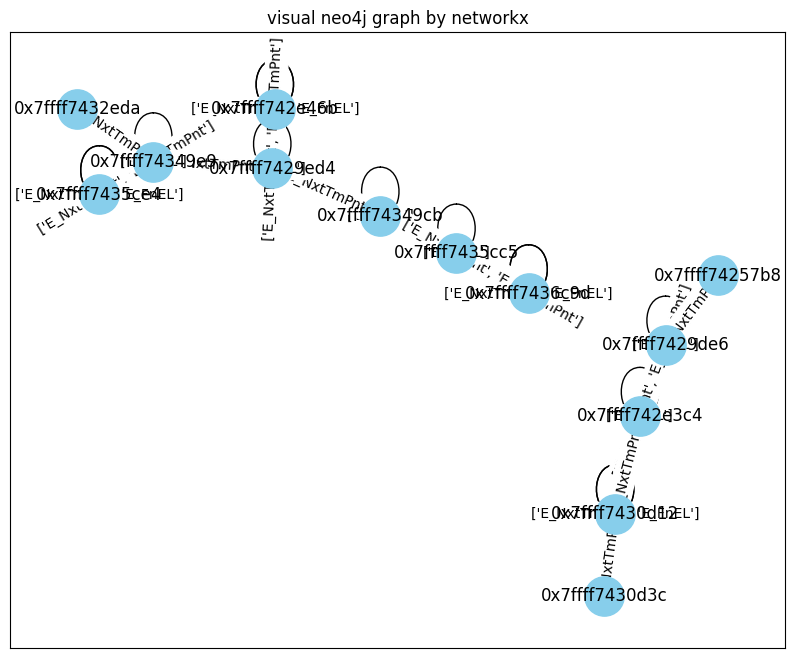

In [84]:


G=visual(driver)

pos = nx.spring_layout(G)  
plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

edge_labels = {(u, v): [d['E_FnEL'] for k, d in G[u][v].items()] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("visual neo4j graph by networkx")
plt.show()

#### 关闭neo4j连接

In [85]:

driver.close()

#### 调试写法

In [86]:
#边列表，简陋
G.edges()

MultiEdgeDataView([('0x7ffff74349cb', '0x7ffff7435cc5'), ('0x7ffff74349cb', '0x7ffff7435cc5'), ('0x7ffff74349cb', '0x7ffff74349cb'), ('0x7ffff74349cb', '0x7ffff7429ed4'), ('0x7ffff7435cc5', '0x7ffff7436c9d'), ('0x7ffff7435cc5', '0x7ffff7436c9d'), ('0x7ffff7435cc5', '0x7ffff7435cc5'), ('0x7ffff7429ed4', '0x7ffff742e46b'), ('0x7ffff7429ed4', '0x7ffff742e46b'), ('0x7ffff7429ed4', '0x7ffff7429ed4'), ('0x7ffff7429ed4', '0x7ffff74349e9'), ('0x7ffff7436c9d', '0x7ffff7436c9d'), ('0x7ffff7436c9d', '0x7ffff7436c9d'), ('0x7ffff742e46b', '0x7ffff742e46b'), ('0x7ffff742e46b', '0x7ffff742e46b'), ('0x7ffff74349e9', '0x7ffff7435ce4'), ('0x7ffff74349e9', '0x7ffff7435ce4'), ('0x7ffff74349e9', '0x7ffff74349e9'), ('0x7ffff74349e9', '0x7ffff7432eda'), ('0x7ffff7435ce4', '0x7ffff7435ce4'), ('0x7ffff7435ce4', '0x7ffff7435ce4'), ('0x7ffff7429de6', '0x7ffff742e3c4'), ('0x7ffff7429de6', '0x7ffff742e3c4'), ('0x7ffff7429de6', '0x7ffff7429de6'), ('0x7ffff7429de6', '0x7ffff74257b8'), ('0x7ffff742e3c4', '0x7ffff7430

In [87]:
#边列表，完备
G.edges(keys=True, data=True)

MultiEdgeDataView([('0x7ffff74349cb', '0x7ffff7435cc5', 0, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff74349cb', '0x7ffff7435cc5', 1, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff74349cb', '0x7ffff74349cb', 0, {'E_FnEL': 'E_FnEL'}), ('0x7ffff74349cb', '0x7ffff7429ed4', 0, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff7435cc5', '0x7ffff7436c9d', 0, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff7435cc5', '0x7ffff7436c9d', 1, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff7435cc5', '0x7ffff7435cc5', 0, {'E_FnEL': 'E_FnEL'}), ('0x7ffff7429ed4', '0x7ffff742e46b', 0, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff7429ed4', '0x7ffff742e46b', 1, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff7429ed4', '0x7ffff7429ed4', 0, {'E_FnEL': 'E_FnEL'}), ('0x7ffff7429ed4', '0x7ffff74349e9', 0, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff7436c9d', '0x7ffff7436c9d', 0, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff7436c9d', '0x7ffff7436c9d', 1, {'E_FnEL': 'E_FnEL'}), ('0x7ffff742e46b', '0x7ffff742e46b', 0, {'E_FnEL': 'E_NxtTmPnt'}), ('0x7ffff742e46b', '0x7ffff742e46b', 1, {'E_FnEL': 'E_FnEL'

In [88]:
#获取关系名字ReltnName列表
[  ( f"{u},{v}", G[u][v].items() ) for u, v in G.edges()]

[('0x7ffff74349cb,0x7ffff7435cc5',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_NxtTmPnt'}, 1: {'E_FnEL': 'E_NxtTmPnt'}}))),
 ('0x7ffff74349cb,0x7ffff7435cc5',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_NxtTmPnt'}, 1: {'E_FnEL': 'E_NxtTmPnt'}}))),
 ('0x7ffff74349cb,0x7ffff74349cb',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_FnEL'}}))),
 ('0x7ffff74349cb,0x7ffff7429ed4',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_NxtTmPnt'}}))),
 ('0x7ffff7435cc5,0x7ffff7436c9d',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_NxtTmPnt'}, 1: {'E_FnEL': 'E_NxtTmPnt'}}))),
 ('0x7ffff7435cc5,0x7ffff7436c9d',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_NxtTmPnt'}, 1: {'E_FnEL': 'E_NxtTmPnt'}}))),
 ('0x7ffff7435cc5,0x7ffff7435cc5',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_FnEL'}}))),
 ('0x7ffff7429ed4,0x7ffff742e46b',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_NxtTmPnt'}, 1: {'E_FnEL': 'E_NxtTmPnt'}}))),
 ('0x7ffff7429ed4,0x7ffff742e46b',
  ItemsView(AtlasView({0: {'E_FnEL': 'E_NxtTmPnt'}, 1: {'E_FnEL': 'E_NxtTmPnt'}}))),
 ('0x7ffff7429e

#### 错误写法

In [89]:
#错误写法，只获取到了最后一个关系名字ReltnName
{(u, v): d['E_FnEL']  for u, v, k, d in G.edges(keys=True, data=True)}

{('0x7ffff74349cb', '0x7ffff7435cc5'): 'E_NxtTmPnt',
 ('0x7ffff74349cb', '0x7ffff74349cb'): 'E_FnEL',
 ('0x7ffff74349cb', '0x7ffff7429ed4'): 'E_NxtTmPnt',
 ('0x7ffff7435cc5', '0x7ffff7436c9d'): 'E_NxtTmPnt',
 ('0x7ffff7435cc5', '0x7ffff7435cc5'): 'E_FnEL',
 ('0x7ffff7429ed4', '0x7ffff742e46b'): 'E_NxtTmPnt',
 ('0x7ffff7429ed4', '0x7ffff7429ed4'): 'E_FnEL',
 ('0x7ffff7429ed4', '0x7ffff74349e9'): 'E_NxtTmPnt',
 ('0x7ffff7436c9d', '0x7ffff7436c9d'): 'E_FnEL',
 ('0x7ffff742e46b', '0x7ffff742e46b'): 'E_FnEL',
 ('0x7ffff74349e9', '0x7ffff7435ce4'): 'E_NxtTmPnt',
 ('0x7ffff74349e9', '0x7ffff74349e9'): 'E_FnEL',
 ('0x7ffff74349e9', '0x7ffff7432eda'): 'E_NxtTmPnt',
 ('0x7ffff7435ce4', '0x7ffff7435ce4'): 'E_FnEL',
 ('0x7ffff7429de6', '0x7ffff742e3c4'): 'E_NxtTmPnt',
 ('0x7ffff7429de6', '0x7ffff7429de6'): 'E_FnEL',
 ('0x7ffff7429de6', '0x7ffff74257b8'): 'E_NxtTmPnt',
 ('0x7ffff742e3c4', '0x7ffff7430d12'): 'E_NxtTmPnt',
 ('0x7ffff742e3c4', '0x7ffff742e3c4'): 'E_FnEL',
 ('0x7ffff7430d12', '0x7ffff7

## 此notebook结束时刻

In [90]:
%%bash
date

2024年 03月 29日 星期五 17:31:10 CST
